# X-ray Holography

X-ray holography is a technique through which a sample's magnetisation can be imaged. It uses the effect of magnetic circular dichroism, in which left and right circularly polarised light are absorbed differently in the presence of a magnetic field parallel to the propagation direction of the light. Due to this effect, only magnetisation parallel the beam direction is able to be imaged. The wavelengths of the X-rays can be tuned to the absorption edges of the different elements present in the sample allowing for element-specific magnetisation to be measured. However, in calculating X-ray holography images from micromagnetic simulations we can use the approximation that the images are non element specific.

In X-ray holography, a coherent beam of circularly polarised X-rays are incident on the sample and a reference slit. The X-rays to scatter from both the sample and the slit which interfere and form a hologram which is incident on the detector. The hologram measured can then be combined with a differential filter and Fourier transformed to reconstruct the holographic image of out-of-plane magnetisation of the sample.
For further information refer to Ref. \[[Duckworth 2011](https://doi.org/10.1364/OE.19.016223)\].

## X-ray holography reference frame

In `mag2exp` the experimental reference for X-ray holography is defined by the X-ray beam propagating along the $z$ direction. Figure is taken from Ref. \[[Turnbull 2020](https://pubs.acs.org/doi/abs/10.1021/acsnano.0c07392)\].

<img src="Figures/Holo_2.png" width="800" height="600">

## The micromagnetic simulation

A micromagnetic simulation can be set up using `Ubermag` to obtain a 3-dimensional magnetic structure.

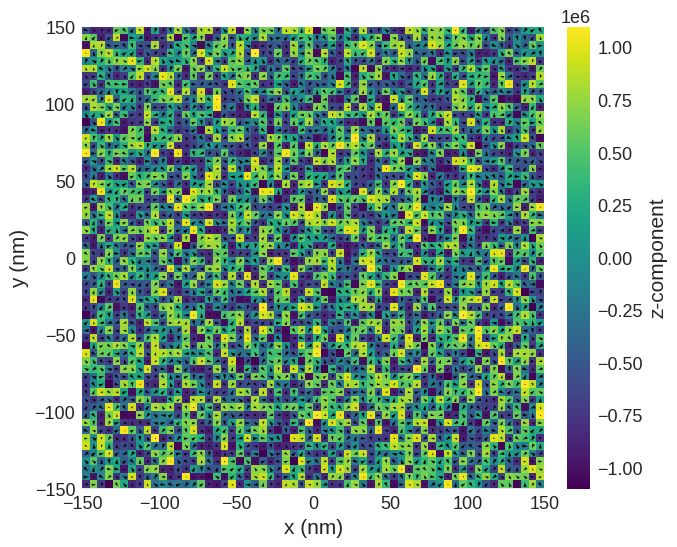

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc
import ubermagutil.units as uu

np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11)
    + mm.DMI(D=4e-3, crystalclass="T")
    + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
    + mm.Demag()
    + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)
system.m.sel("z").mpl()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/10/18 12:13]... (6.2 s)


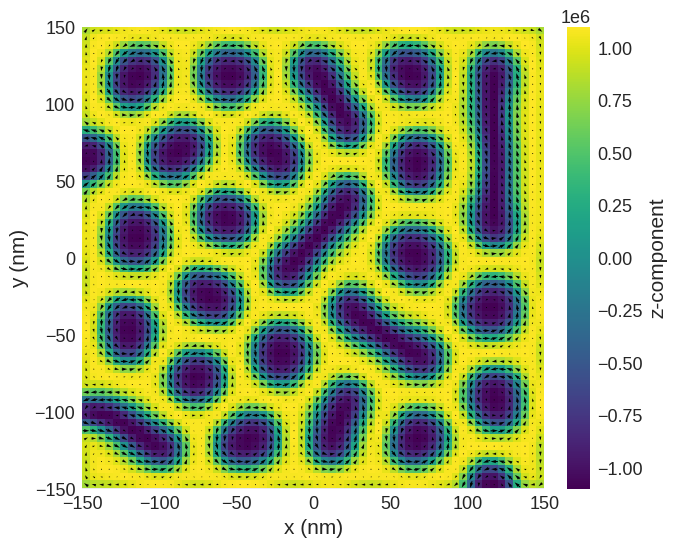

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

## Computing X-ray holography images

As X-ray beam is defined as propagating along the $z$ direction, the results from the image reconstruction of the X-ray holograph is comparable to the integrated $z$ component of magnetisation along the beam direction $m_z$. 

In [3]:
import mag2exp

holo = mag2exp.x_ray.holography(system.m)

The holographic images are `discretisedfield` objects, the built in plotting functionality can be used to view it.

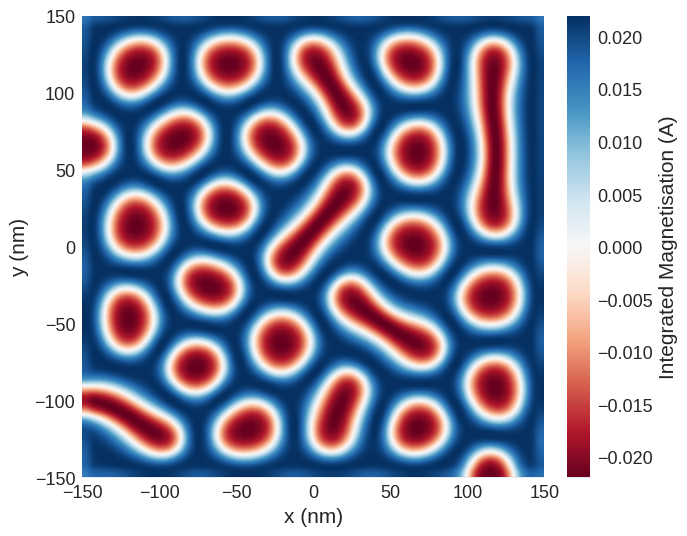

In [4]:
holo.mpl.scalar(
    cmap="RdBu",
    interpolation="spline16",
    colorbar_label=r"Integrated Magnetisation (A)",
)

Often holographic experiments can be limited by their resolution. In order to take this into account when computing holographic images the `holography` function has the ability to convolute the output with a 2-dimensional Gaussian to view different spatial resolutions. A value for the Full Width Half Maximum (FWHM) of the Gaussian can be specified (in meters) for each dimension. For example a convolution of a 2 dimensional Gaussian with the holographic image is shown below.

In [5]:
holo2 = mag2exp.x_ray.holography(system.m, fwhm=(25e-9, 25e-9))

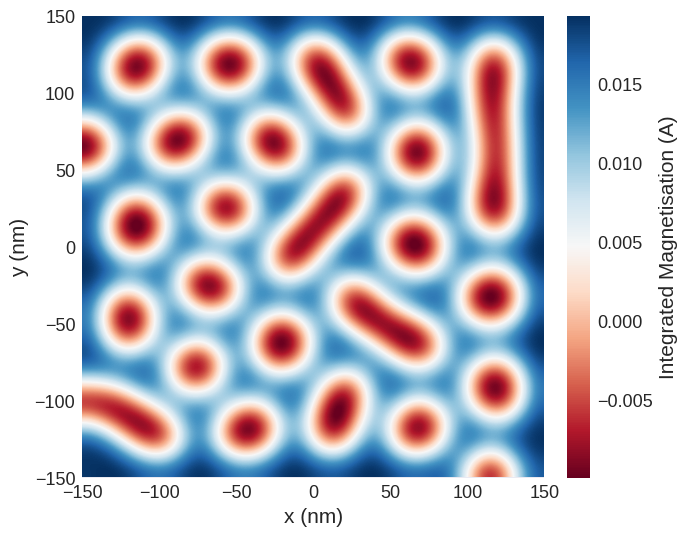

In [6]:
holo2.mpl.scalar(
    cmap="RdBu",
    interpolation="spline16",
    colorbar_label=r"Integrated Magnetisation (A)",
)

## Quick plots

`mag2exp` has an integrated `quick_plots` functionality which is designed to be easy to use and output figures of the desired quantities directly from the magnetisation texture with all the intermediary calculations performed under the hood. These figures are created with set themes by design, and only take arguments relevant to the quantities being calculated.

Holographic images can be plotted using 

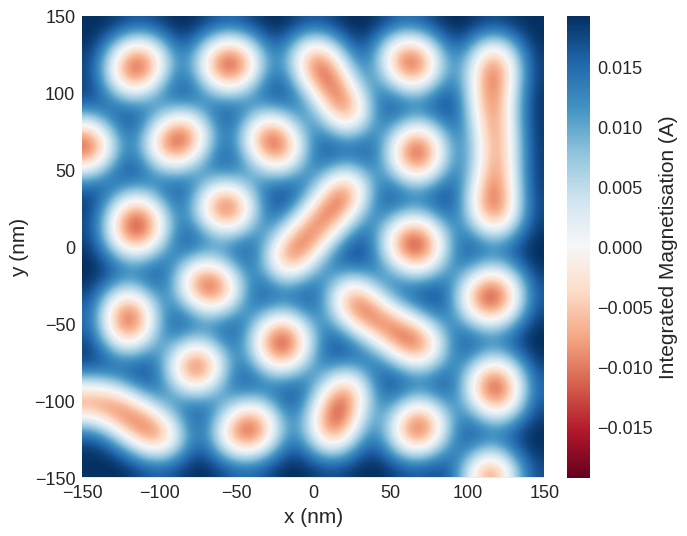

In [7]:
mag2exp.quick_plots.x_ray_holography(system.m, fwhm=(25e-9, 25e-9))

## Rotations
`discretisedfield` objects have the functionality to be rotated. We can make use of this functionality with the `mag2exp` package in order to look along any arbitrary direction with X-ray holography. This assumes knowledge of how to use the `FieldRotator`. A tutorials on this topic can be found in the `discretisedfield` documentation.

Firstly we can create a `FieldRotator` of our field. As the reference frame is defined along the $z$ direction, if we want to image along the \[111\] direction we can use the `align_vector` method using `initial=(1, 1, 1)` and `final=(0, 0, 1)`.

In [8]:
field_rotator = df.FieldRotator(system.m)
field_rotator.rotate("align_vector", initial=(1, 1, 1), final=(0, 0, 1))

`field_rotator.field` allows us to access the rotated field. We can visualise this "3d" rotation using `k3d`.

In [9]:
field_rotator.field.norm.k3d.nonzero()

Output()

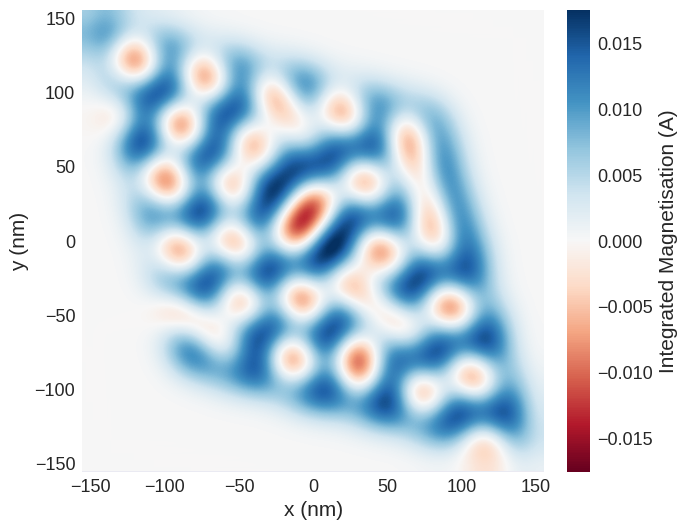

In [10]:
mag2exp.quick_plots.x_ray_holography(field_rotator.field, fwhm=(25e-9, 25e-9))